In [1]:
import os
from tqdm import tqdm # smart progress bar


# ================  GRAPHICS
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_params
 
# get our styles
mpl_default = rc_params()
 
import seaborn as sns
sns.set(rc=mpl_default)
 
%matplotlib inline
plt.rcParams = mpl_default

# ================  NUMBERS AND MATHS AND THINGS
import pandas as pd
import numpy as np

# BEES colormap! Black -> Yellow
CMAP = [(0,0,0),
        (22,0,0),
        (43,0,0),
        (77,14,0),
        (149,68,0),
        (220,123,0),
        (255,165,0),
        (255,192,0),
        (255,220,0),
        (255,235,0),
        (255,245,0),
        (255,255,0)]


bees_cm = mpl.colors.ListedColormap(np.array(CMAP)/255.)

In [2]:
# load the labels using pandas
labels = pd.read_csv("data/train_labels.csv",
                     index_col=0)

submission_format = pd.read_csv("data/SubmissionFormat.csv",
                                index_col=0)

print "Number of training examples is: ", labels.shape[0]
print "Predictions should be type:", labels.dtypes[0]
labels.head()

Number of training examples is:  3969
Predictions should be type: float64


,genus
id,
520,1
3800,1
3289,1
2695,1
4922,1


In [4]:
def get_image(row_or_str, root="data/images/"):
    # if we have an instance from the data frame, pull out the id
    # otherwise, it is a string for the image id
    if isinstance(row_or_str, pd.core.series.Series):
        row_id = row_or_str.name
    else:
        row_id = row_or_str
    
    filename = "{}.jpg".format(row_id)
    
    # test both of these so we don't have to specify. Image should be
    # in one of these two. If not, we let Image.open raise an exception.
    train_path = os.path.join(root, "train", filename)
    test_path = os.path.join(root, "test", filename)
    
    file_path = train_path if os.path.exists(train_path) else test_path
    
    return np.array(Image.open(file_path), dtype=np.int32)
        

# make sure it works for strings and series
assert (get_image(labels.iloc[0]) == get_image("520")).all()

# confirm images are the same shape
print "Size of image 520:  ", get_image("520").shape
print "Size of image 1001: ", get_image("1001").shape

Size of image 520:   (200, 200, 3)
Size of image 1001:  (200, 200, 3)


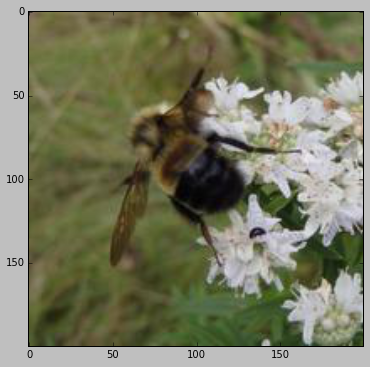

In [5]:
# imshow expects floats between 0-1, but we have
# integers 0-255 from PIL so we need to rescale to view the image
plt.imshow((get_image("520") / 255.))

array([ 201.,  194.,  127., ...,  179.,  177.,  171.])

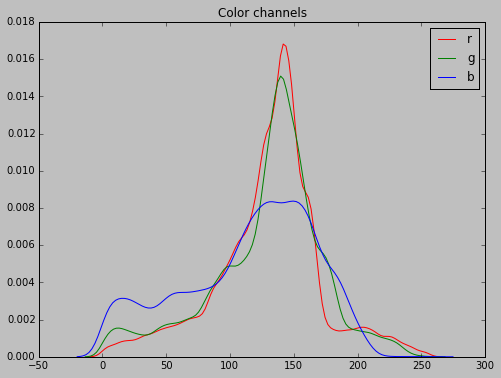

In [5]:
def extract_rgb_info(rgb, ax=None):
    """Extract color statistics as features:
        - pixel values (flattened)
        - X, Y sums per channel
        - percentiles per channel
        - percentile diffs per channel

        Plots if ax is passed
    """
    # toss alpha if it exists
    if rgb.shape[2] == 4:
        rgb = rgb[:, :, :3]

    # start with raw pixel values as features
    features = [rgb.flatten()]

    # add some basic statistics on the color channels (R, G, B)
    for channel in range(3):
        this_channel = rgb[:, :, channel].astype(np.float)
        sums = np.hstack([this_channel.sum(),
                          this_channel.sum(axis=0),
                          this_channel.sum(axis=1)])

        # percentiles
        ps = [1, 3, 5, 10, 50, 90, 95, 97, 99]
        percentiles = np.array(np.percentile(this_channel, ps))
        diff = percentiles[-4:] - percentiles[:4]
        
        # plot if we have been passed an axis
        if ax is not None:
            channel_name = ['r', 'g', 'b'][channel]       
            sns.kdeplot(this_channel.flatten(),
                        ax=ax,
                        label=channel_name,
                        color=channel_name)
            ax.set_title("Color channels")

        
        # store the features for this channel
        features += [sums, percentiles, diff]
        
    # return all the color features as a flat array
    return np.hstack(features).flatten()

extract_rgb_info(get_image("1974"), ax=plt.gca())

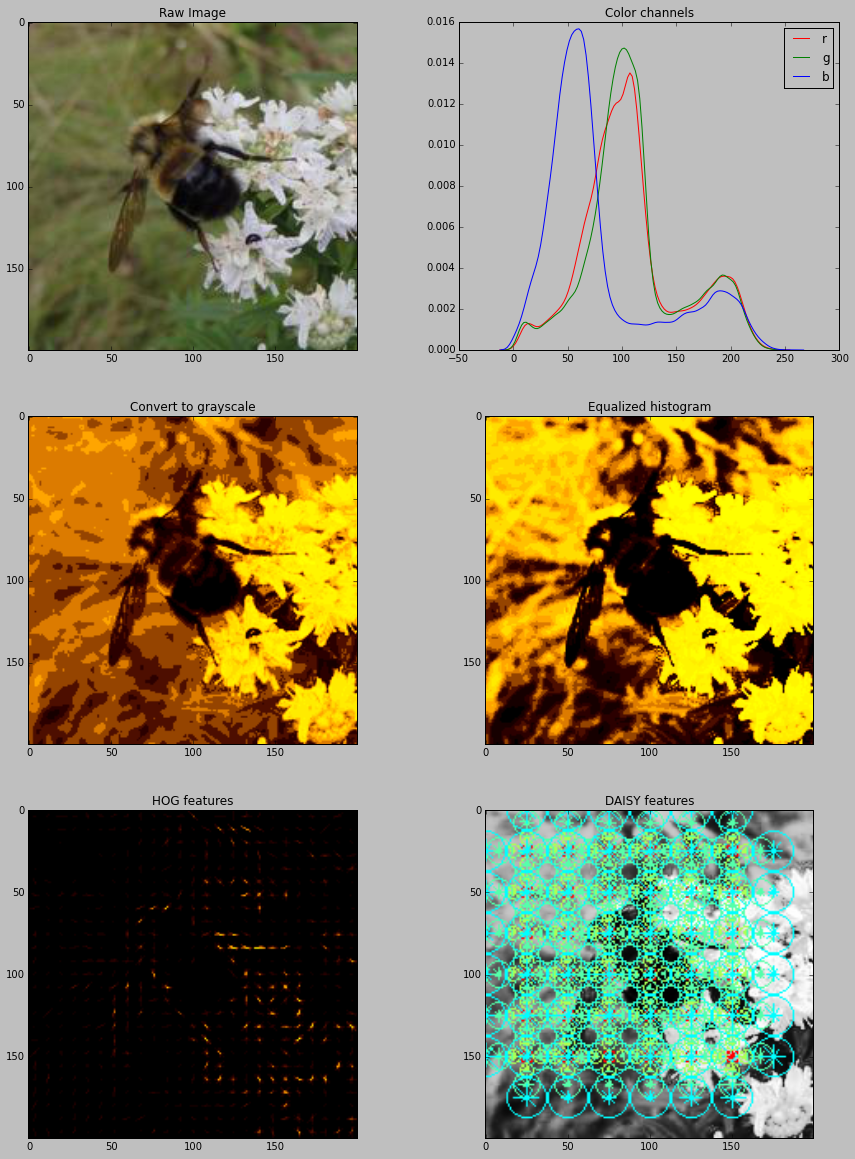

In [6]:
from skimage.feature import daisy
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist

def preprocess(img, demo=False):
    """ Turn raw pixel values into features.
    """
    
    def _demo_plot(img, stage="", is_ints=False, axes_idx=0):
        """ Utility to visualize the features we're building
        """
        if demo:
            axes[axes_idx].imshow(img / 255. if is_ints else img,
                                  cmap=bees_cm)
            axes[axes_idx].set_title(stage)
        return axes_idx + 1

    if demo:
        fig, axes = plt.subplots(3, 2, figsize=(15, 20))
        axes = axes.flatten()
    
    # track which subplot we're plotting to
    axes_idx = 0
    axes_idx = _demo_plot(img, stage="Raw Image", is_ints=True, axes_idx=axes_idx)
        
    # FEATURE 1: Raw image and color data    
    if demo:
        color_info = extract_rgb_info(img, ax=axes[axes_idx])
        axes_idx += 1
    else:
        color_info = extract_rgb_info(img)
    
    # remove color information (hog and daisy only work on grayscale)
    gray = rgb2gray(img)
    axes_idx = _demo_plot(gray, stage="Convert to grayscale", axes_idx=axes_idx)
    
    # equalize the image
    gray = equalize_hist(gray)
    axes_idx = _demo_plot(gray, stage="Equalized histogram", axes_idx=axes_idx)
    
    # FEATURE 2: histogram of oriented gradients features
    hog_features = hog(gray,
                       orientations=12,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(1, 1),
                       visualise=demo)
    
    # if demo, we actually got a tuple back; unpack it and plot
    if demo:
        hog_features, hog_image = hog_features
        axes_idx = _demo_plot(hog_image, stage="HOG features", axes_idx=axes_idx)
        
    # FEATURE 3: DAISY features - sparser for demo so can be visualized
    params = {'step': 25, 'radius': 25, 'rings': 3} if demo \
             else {'step': 10, 'radius': 15, 'rings': 4}
    daisy_features = daisy(gray,
                           histograms=4,
                           orientations=8,
                           normalization='l1',
                           visualize=demo,
                           **params)
        
    if demo:
        daisy_features, daisy_image = daisy_features
        axes_idx = _demo_plot(daisy_image, stage="DAISY features", axes_idx=axes_idx)
    
    # return a flat array of the raw, hog and daisy features
    return np.hstack([color_info, hog_features, daisy_features.flatten()])


preprocess_result = preprocess(get_image("520"), demo=True)


In [7]:
def create_feature_matrix(label_dataframe):
    n_imgs = label_dataframe.shape[0]
    
    # initialized after first call to 
    feature_matrix = None
    
    for i, img_id in tqdm(enumerate(label_dataframe.index)):
        features = preprocess(get_image(img_id))
        
        # initialize the results matrix if we need to
        # this is so n_features can change as preprocess changes
        if feature_matrix is None:
            n_features = features.shape[0]
            feature_matrix = np.zeros((n_imgs, n_features), dtype=np.float32)
            
        if not features.shape[0] == n_features:
            print "Error on image {}".format(img_id)
            features = features[:n_features]
        
        feature_matrix[i, :] = features
        
    return feature_matrix

# turn those images into features!
# bees_features = create_feature_matrix(labels)

# save in case we need to load later; creating this takes
# a little while and it ends up being ~3GBs
# np.save("bees_features.npy", bees_features)

In [8]:
bees_features = np.load("bees_features.npy")

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
bees_stand = ss.fit_transform(bees_features)
bees_stand.shape


(3969, 168046)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4e3)
bees_pca = pca.fit_transform(bees_stand)

/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:311: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.components_ = components_[:n_components]
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:312: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.explained_variance_ = explained_variance_[:n_components]
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:313: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  explained_variance_ratio_ = explained_variance_ratio_[:n_components]
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:242: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  U = U[:, :self.n_components_]
/home/thiebau

In [11]:
from sklearn import svm

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# split into a local train/test set
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.2,
                                                    random_state=1234123)

# SVM parameters often set on log scale
params_to_try = {
    'C': [10**i for i in range(0, 2)],
    'gamma': [10**i for i in range(-7, -5)],
}

gs = GridSearchCV(svm.SVC(class_weight='auto', kernel='rbf', probability=True),
                  param_grid=params_to_try,
                  cv=3,
                  scoring='roc_auc',
                  n_jobs=-1)

gs.fit(X_train, y_train)

print "Best parameters:", gs.best_params_
print "Best score:", gs.best_score_


Best parameters: {'C': 1, 'gamma': 1e-06}
Best score: 0.678911475346


/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)
/home/thiebaut/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favo

In [12]:
preds = gs.best_estimator_.predict_proba(X_test)

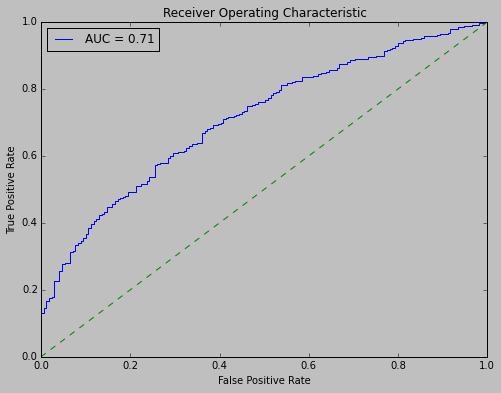

In [13]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,
                                                                preds[:, 1],
                                                                pos_label=1)

roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,
         true_positive_rate,
         label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
sf = pd.read_csv("data/SubmissionFormat.csv", index_col=0)

def make_predictions(submission_format_df,output_filepath="my_submission.csv"):
    prediction_df = submission_format_df.copy()
    
    # create features
    test_features = create_feature_matrix(submission_format_df)
    test_features_stand = ss.transform(test_features)   
    test_features_pca = pca.transform(test_features_stand)
    
    # predict with the best estimator from the grid search
    preds = gs.best_estimator_.predict_proba(test_features_pca)
    
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df.genus = preds[:, 1]
    prediction_df.to_csv(output_filepath)
    
    return prediction_df
    
pred_df = make_predictions(sf, output_filepath="raw_hog_daisy_rbf.csv")
pred_df.head()

,genus
id,
2783,0.844870
2175,0.872798
4517,0.876795
2831,0.733831
3556,0.826202


In [14]:
preds_train = gs.best_estimator_.predict_proba(bees_pca)

In [19]:
preds_train

array([[ 0.08088169,  0.91911831],
       [ 0.11522894,  0.88477106],
       [ 0.10070617,  0.89929383],
       ..., 
       [ 0.30090512,  0.69909488],
       [ 0.34225292,  0.65774708],
       [ 0.35491155,  0.64508845]])

In [21]:
# load the labels using pandas
labels = pd.read_csv("data/train_labels.csv",
                     index_col=0)
def make_predictions(submission_format_df, preds_train, output_filepath="my_submission.csv"):
    prediction_df = submission_format_df.copy()
    
    # create features
    """"
    test_features = create_feature_matrix(submission_format_df)
    test_features_stand = ss.transform(test_features)   
    test_features_pca = pca.transform(test_features_stand)
    """
    # predict with the best estimator from the grid search
    # preds = gs.best_estimator_.predict_proba(test_features_pca)
    
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df.genus = preds_train[:, 1]
    prediction_df.to_csv(output_filepath)
    
    return prediction_df
    
pred_df = make_predictions(labels, preds_train, output_filepath="raw_hog_daisy_rbf_train.csv")
pred_df.head()

,genus
id,
520,0.919118
3800,0.884771
3289,0.899294
2695,0.880367
4922,0.920406
